In [1]:
"""Use Perona-Malik regularistion to deblur image"""

'Use Perona-Malik regularistion to deblur image'

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.sparse as sp

from deblurring.blurring import blur_and_noise
from deblurring.solvers import LSQRSolver
from common.operators import derivative_operator, dx_operator, dy_operator, identity_operator, laplacian_operator, perona_malik_operator
from evaluation.tuning import StandardTuner, IterativeTuner

[INFO] 2024-11-24 07:28:26 | Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16. | numexpr.utils-_init_num_threads:148
[INFO] 2024-11-24 07:28:26 | NumExpr defaulting to 16 threads. | numexpr.utils-_init_num_threads:161


Estimated noise variance 2.6173394727900968e-05 vs. actual 2.5899715383858184e-05


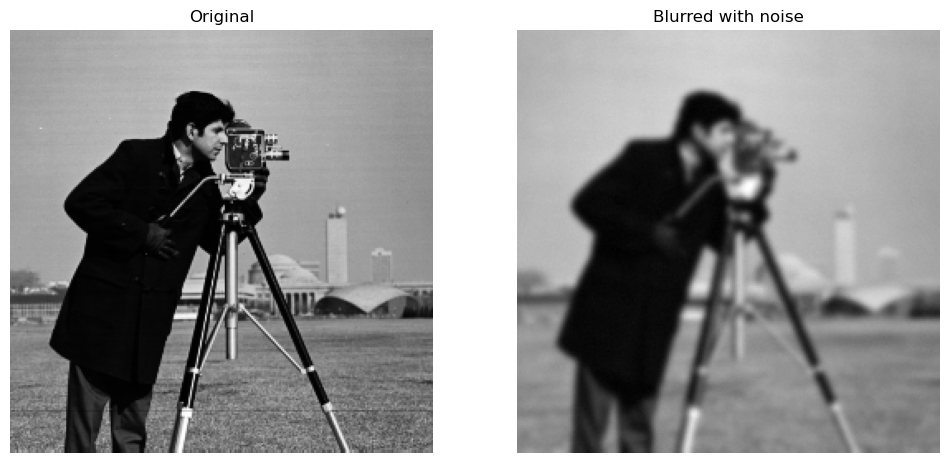

In [3]:
"""Read image and blur with added noise"""

f = plt.imread("../../data/Cameraman256.png")
f = (f - f.min()) / (f.max() - f.min())

theta = 0.02 * np.std(f)  # 2% noise
sigma = 2.0
kernel = partial(gaussian_filter, sigma=sigma)
g = blur_and_noise(f, kernel, theta)
noise_variance = np.var(blur_and_noise(np.zeros_like(g), kernel, theta))
print(f"Estimated noise variance {noise_variance} vs. actual {np.square(theta)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f, cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(g, cmap="gray")
plt.axis("off")
plt.title("Blurred with noise")
plt.show()

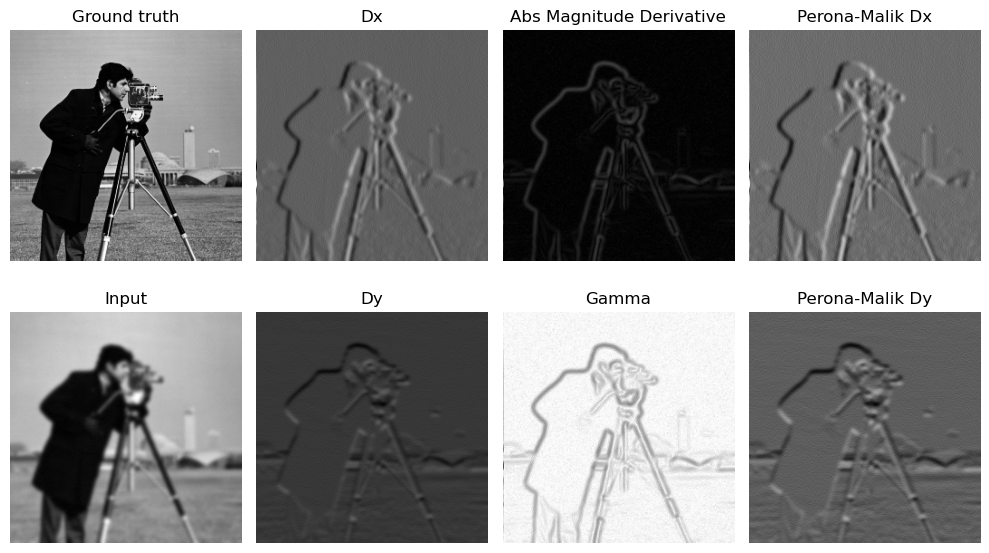

In [4]:
"""Visualise Perona-Malik regularisation"""

Dx = dx_operator(g, conv_mode="periodic")
Dy = dy_operator(g, conv_mode="periodic")
flat_dims = np.prod(g.shape)
dx_g = Dx @ g.flatten()
dy_g = Dy @ g.flatten()
abs_derivative = np.sqrt(np.square(dx_g) + np.square(dy_g))
threshold = 0.5 * np.max(abs_derivative)
gamma = np.exp(-abs_derivative / threshold)
gamma_diag_hat = np.sqrt(sp.diags(gamma.ravel()))
pm = sp.vstack([gamma_diag_hat @ Dx, gamma_diag_hat @ Dy])
pm_g = pm @ g.flatten()

fig, axs = plt.subplots(2, 4, figsize=(10, 6))

axs[0, 0].imshow(f, cmap="gray")
axs[0, 0].set_title("Ground truth")
axs[0, 0].axis("off")
axs[0, 1].imshow(dx_g.reshape(g.shape), cmap="gray")
axs[0, 1].set_title("Dx")
axs[0, 1].axis("off")
axs[0, 2].imshow(abs_derivative.reshape(g.shape), cmap="gray")
axs[0, 2].set_title("Abs Magnitude Derivative")
axs[0, 2].axis("off")
axs[0, 3].imshow(pm_g[0:flat_dims].reshape(g.shape), cmap="gray")
axs[0, 3].set_title("Perona-Malik Dx")
axs[0, 3].axis("off")
axs[1, 0].imshow(g, cmap="gray")
axs[1, 0].set_title("Input")
axs[1, 0].axis("off")
axs[1, 1].imshow(dy_g.reshape(g.shape), cmap='gray')
axs[1, 1].set_title("Dy")
axs[1, 1].axis("off")
axs[1, 2].imshow(gamma.reshape(g.shape), cmap="gray")
axs[1, 2].set_title("Gamma")
axs[1, 2].axis("off")
axs[1, 3].imshow(pm_g[flat_dims:].reshape(g.shape), cmap="gray")
axs[1, 3].set_title("Perona-Malik Dy")
axs[1, 3].axis("off")

plt.tight_layout()
plt.show()

In [5]:
"""Set up parameters"""

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

[WARNING] 2024-11-24 07:28:27 | No valid reference provided | evaluation.eval_metrics-__init__:59
[INFO] 2024-11-24 07:28:28 | Alpha 1e-08: discrepancy -5.660395466595242e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:28 | Alpha 1e-07: discrepancy -5.660395060059431e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:29 | Alpha 1e-06: discrepancy -5.660354777301192e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:29 | Alpha 1e-05: discrepancy -5.656670453016914e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:29 | Alpha 0.0001: discrepancy -5.47618972526592e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:30 | Alpha 0.001: discrepancy -3.907271927806307e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:30 | Alpha 0.01: discrepancy 2.906188751686455e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:30 | Alpha 0.1: discrepancy 0.00230219798572003

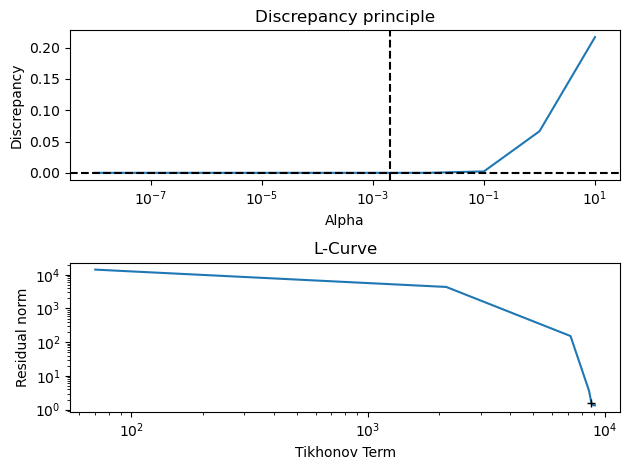

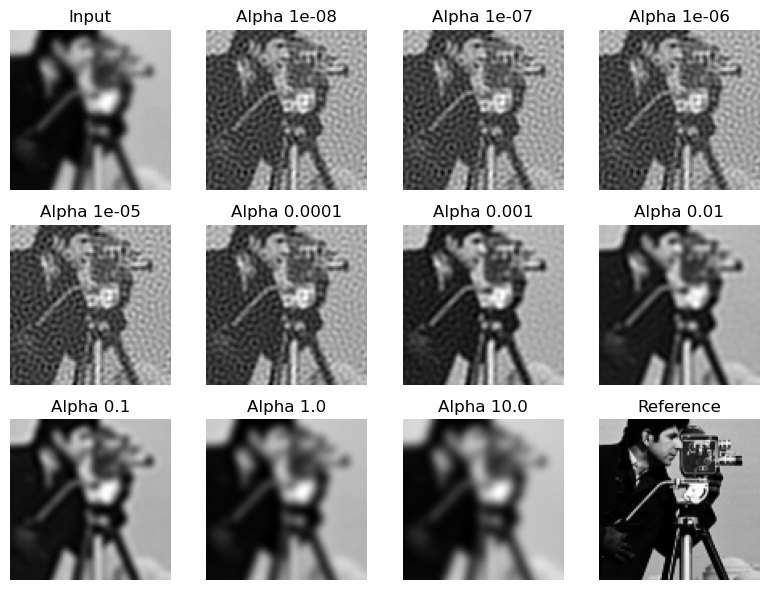

Optimal alpha: 0.0020666164361657978
DP: -2.1500126342582244e-06, MSE: 0.0032730972992602108


In [6]:
"""Optimise for TK0"""

lsqr_tk0 = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_tk0.parameter_sweep(alphas=alphas, L=identity_operator(f), save_imgs=True)
lsqr_tk0.display_metrics()
lsqr_tk0.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tk0.optimal_alpha}")
print(f"DP: {lsqr_tk0.optimal_metrics['discrepancy']}, MSE: {lsqr_tk0.optimal_metrics['MSE']}")

[WARNING] 2024-11-24 07:28:33 | No valid reference provided | evaluation.eval_metrics-__init__:59
[INFO] 2024-11-24 07:28:34 | Alpha 1e-08: discrepancy -5.660389662476751e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:35 | Alpha 1e-07: discrepancy -5.660335969603388e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:36 | Alpha 1e-06: discrepancy -5.659661775006171e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:37 | Alpha 1e-05: discrepancy -5.641898178983963e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:38 | Alpha 0.0001: discrepancy -5.2528016829245634e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:39 | Alpha 0.001: discrepancy -3.825267528053084e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:39 | Alpha 0.01: discrepancy 1.5709551563133635e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:39 | Alpha 0.1: discrepancy 4.50406388624708

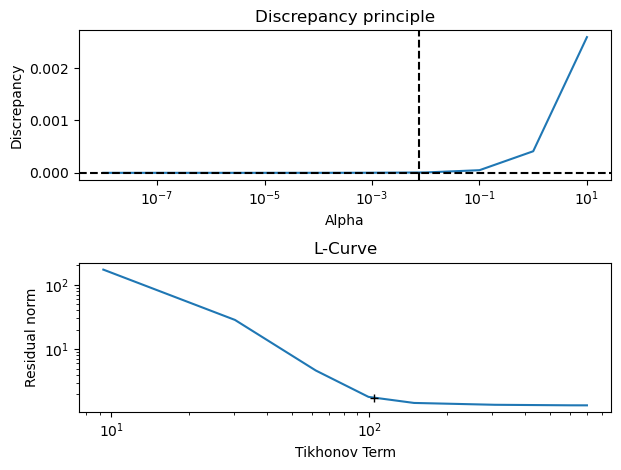

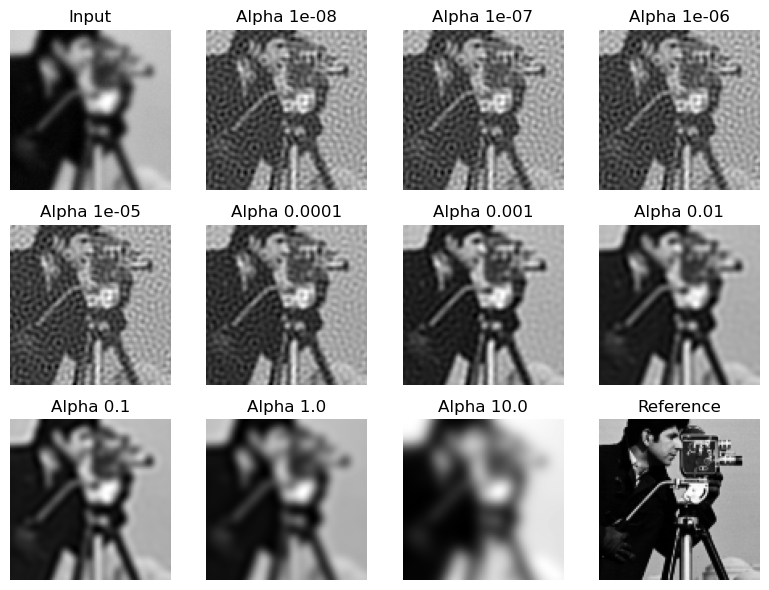

Optimal alpha: 0.007379908644655899
DP: 1.612304643114267e-07, MSE: 0.003642953904059931


In [7]:
"""Optimise for TK1"""

lsqr_tk1 = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_tk1.parameter_sweep(
    alphas=alphas,
    L=derivative_operator(f, conv_mode="periodic"),
    save_imgs=True
)
lsqr_tk1.display_metrics()
lsqr_tk1.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tk1.optimal_alpha}")
print(f"DP: {lsqr_tk1.optimal_metrics['discrepancy']}, MSE: {lsqr_tk1.optimal_metrics['MSE']}")

[WARNING] 2024-11-24 07:28:41 | No valid reference provided | evaluation.eval_metrics-__init__:59
[INFO] 2024-11-24 07:28:42 | Alpha 1e-08: discrepancy -5.660390110406357e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:42 | Alpha 1e-07: discrepancy -5.6603407631671175e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:42 | Alpha 1e-06: discrepancy -5.659740331890757e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:43 | Alpha 1e-05: discrepancy -5.64507274948629e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:43 | Alpha 0.0001: discrepancy -5.319594017509373e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:44 | Alpha 0.001: discrepancy -4.119467333090966e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:44 | Alpha 0.01: discrepancy -8.700271293539562e-07 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:28:44 | Alpha 0.1: discrepancy 2.305878660745568

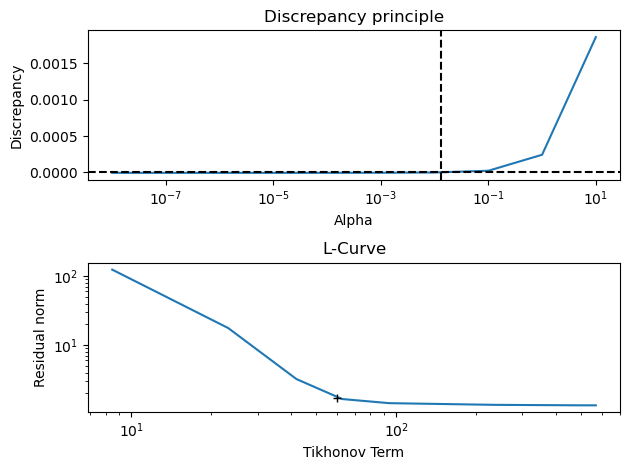

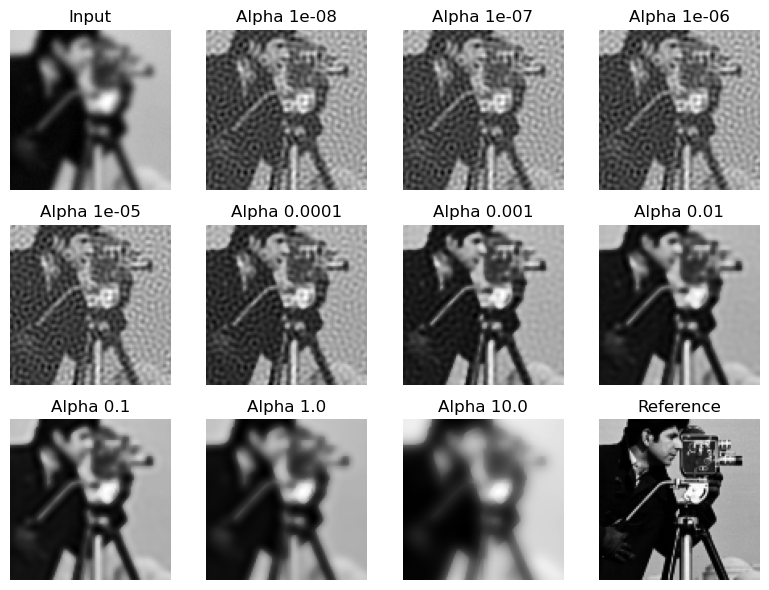

Optimal alpha: 0.013272307708317508
DP: 8.578975372708258e-08, MSE: 0.0027882993861821897


In [8]:
"""Optimise and generate example images Perona-Malik"""

lsqr_pm = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_pm.parameter_sweep(
    alphas=alphas,
    L=perona_malik_operator(f, conv_mode="periodic"),
    save_imgs=True
)
lsqr_pm.display_metrics()
lsqr_pm.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_pm.optimal_alpha}")
print(f"DP: {lsqr_pm.optimal_metrics['discrepancy']}, MSE: {lsqr_pm.optimal_metrics['MSE']}")

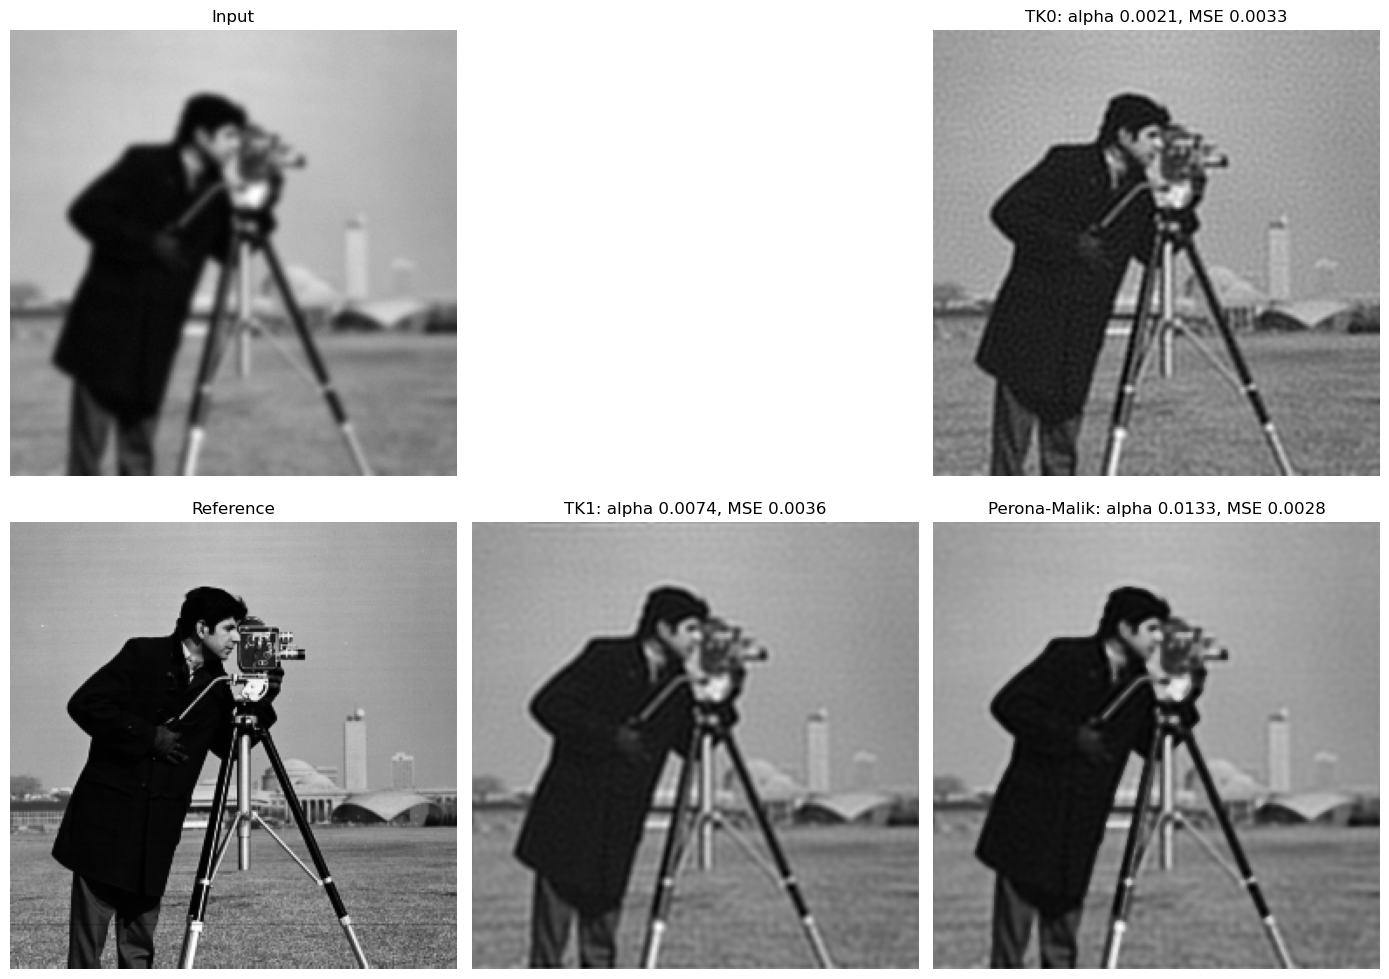

In [9]:
"""Compare regularisation techniques"""

_, axs = plt.subplots(2, 3, figsize=(14, 10))

axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[0, 1].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 2].imshow(lsqr_tk0._optimal_f_hat, cmap="gray")
axs[0, 2].set_title(f"TK0: alpha {lsqr_tk0.optimal_alpha:.4f}, MSE {lsqr_tk0.optimal_metrics['MSE']:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_tk1._optimal_f_hat, cmap="gray")
axs[1, 1].set_title(f"TK1: alpha {lsqr_tk1.optimal_alpha:.4f}, MSE {lsqr_tk1.optimal_metrics['MSE']:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm._optimal_f_hat, cmap="gray")
axs[1, 2].set_title(f"Perona-Malik: alpha {lsqr_pm.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

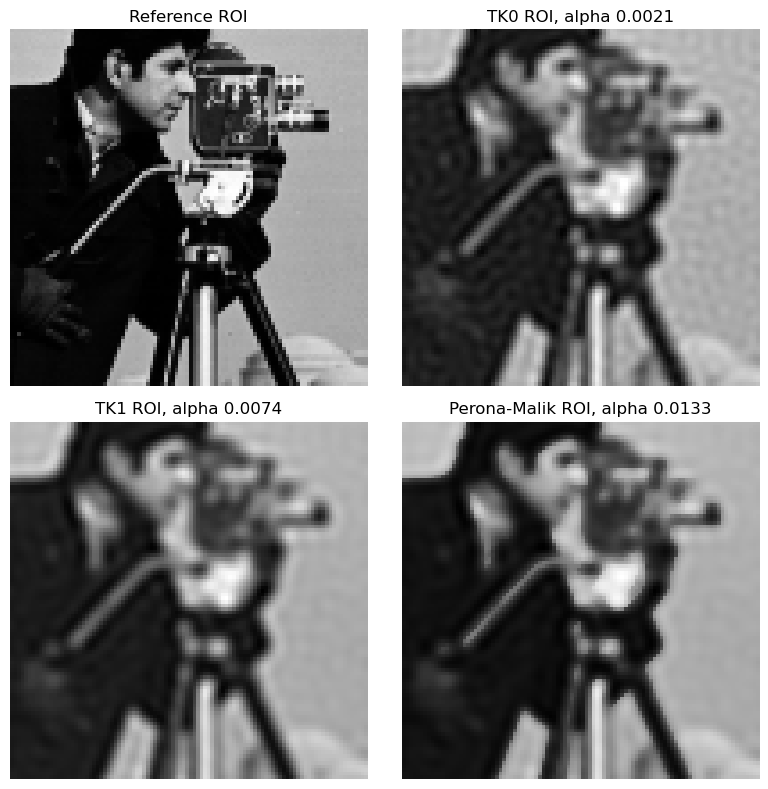

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(f[50:150, 80:180], cmap="gray")
axs[0, 0].set_title("Reference ROI")
axs[0, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 1].set_title(f"TK0 ROI, alpha {lsqr_tk0.optimal_alpha:.4f}")
axs[0, 1].axis("off")
axs[1, 0].imshow(lsqr_tk1.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 0].set_title(f"TK1 ROI, alpha {lsqr_tk1.optimal_alpha:.4f}")
axs[1, 0].axis("off")
axs[1, 1].imshow(lsqr_pm.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 1].set_title(f"Perona-Malik ROI, alpha {lsqr_pm.optimal_alpha:.4f}")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

[WARNING] 2024-11-24 07:28:46 | No valid reference provided | evaluation.eval_metrics-__init__:59
[WARNING] 2024-11-24 07:30:04 | Alpha 1e-08: Maximum iterations reached | evaluation.tuning-parameter_sweep:303
[WARNING] 2024-11-24 07:31:23 | Alpha 1e-07: Maximum iterations reached | evaluation.tuning-parameter_sweep:303
[INFO] 2024-11-24 07:32:31 | Alpha 1e-06: discrepancy -7.777813112483334e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:32:57 | Alpha 1e-05: discrepancy -6.639301164135699e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:33:06 | Alpha 0.0001: discrepancy -5.4411128920775264e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:33:19 | Alpha 0.001: discrepancy -4.07684103720373e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:33:41 | Alpha 0.01: discrepancy -4.164044995520591e-07 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 07:33:53 | Alpha 0.1: discrepancy 2.785255424149233e-05 | evaluat

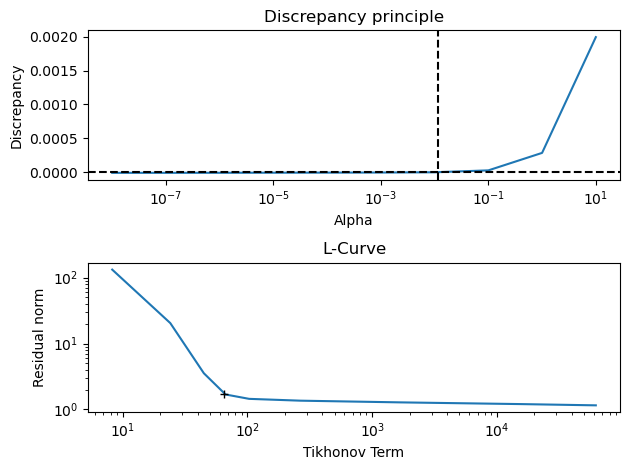

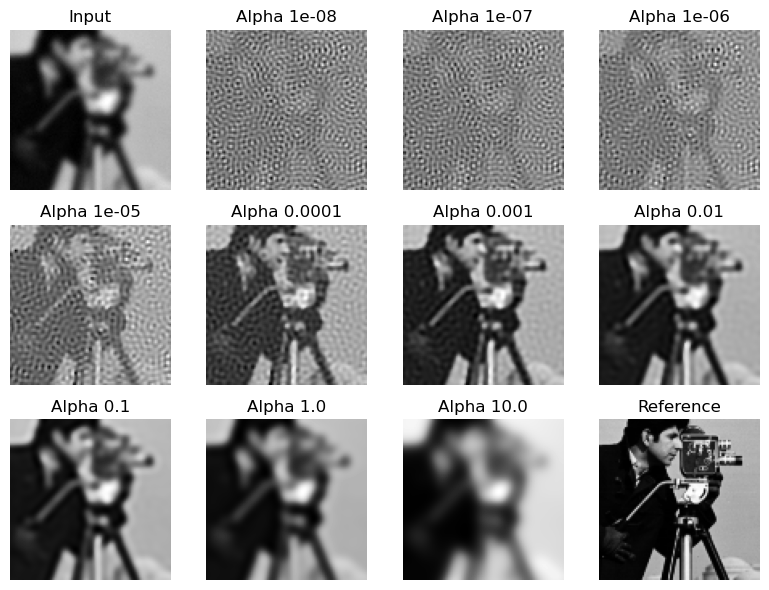

Optimal alpha: 0.013272307708317508
DP: 8.578975372708258e-08, MSE: 0.0027882993861821897


In [11]:
"""Generate example images using iterative Perona-Malik"""

lsqr_pm_iter = IterativeTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_pm_iter.parameter_sweep(
    alphas=alphas,
    L=perona_malik_operator,
    save_imgs=True
)
lsqr_pm_iter.display_metrics()
lsqr_pm_iter.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_pm.optimal_alpha}")
print(f"DP: {lsqr_pm.optimal_metrics['discrepancy']}, MSE: {lsqr_pm.optimal_metrics['MSE']}")

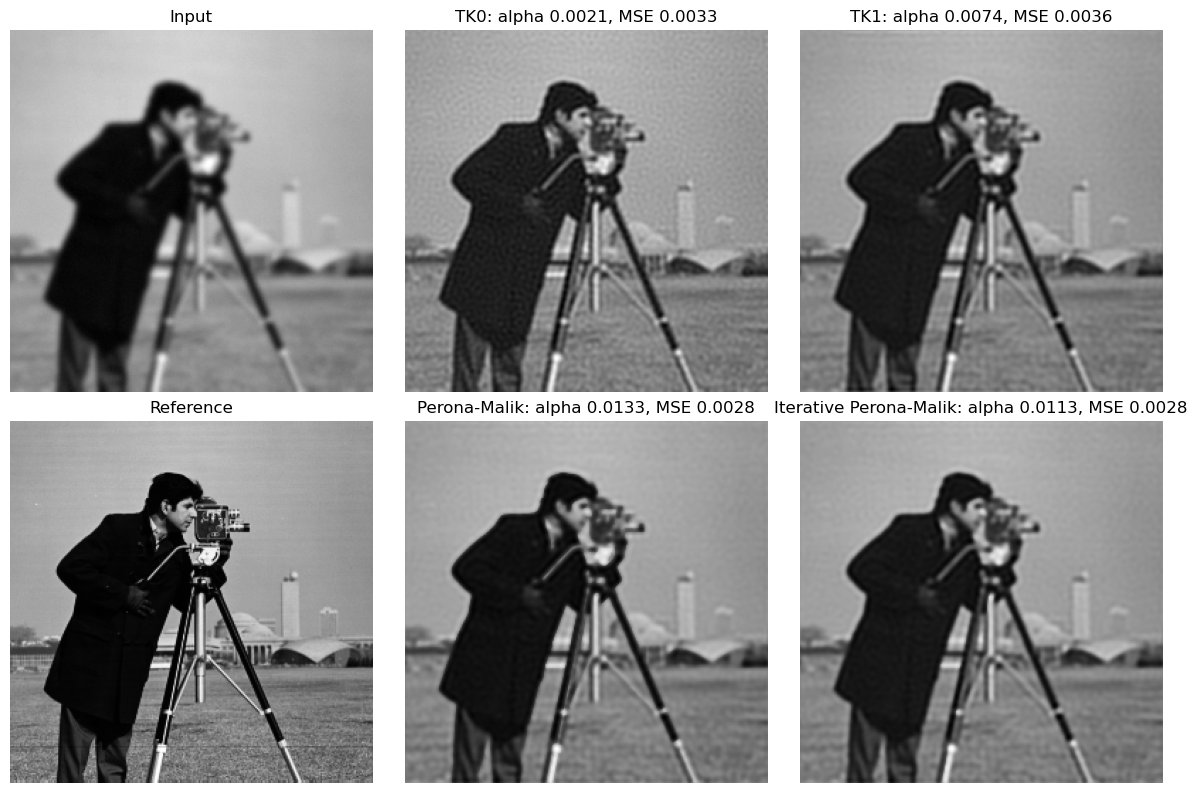

In [12]:
"""Compare regularisation techniques"""

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0.optimal_f_hat, cmap="gray")
axs[0, 1].set_title(f"TK0: alpha {lsqr_tk0.optimal_alpha:.4f}, MSE {lsqr_tk0.optimal_metrics['MSE']:.4f}")
axs[0, 1].axis("off")
axs[0, 2].imshow(lsqr_tk1.optimal_f_hat, cmap="gray")
axs[0, 2].set_title(f"TK1: alpha {lsqr_tk1.optimal_alpha:.4f}, MSE {lsqr_tk1.optimal_metrics['MSE']:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_pm.optimal_f_hat, cmap="gray")
axs[1, 1].set_title(f"Perona-Malik: alpha {lsqr_pm.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm_iter.optimal_f_hat, cmap="gray")
axs[1, 2].set_title(f"Iterative Perona-Malik: alpha {lsqr_pm_iter.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

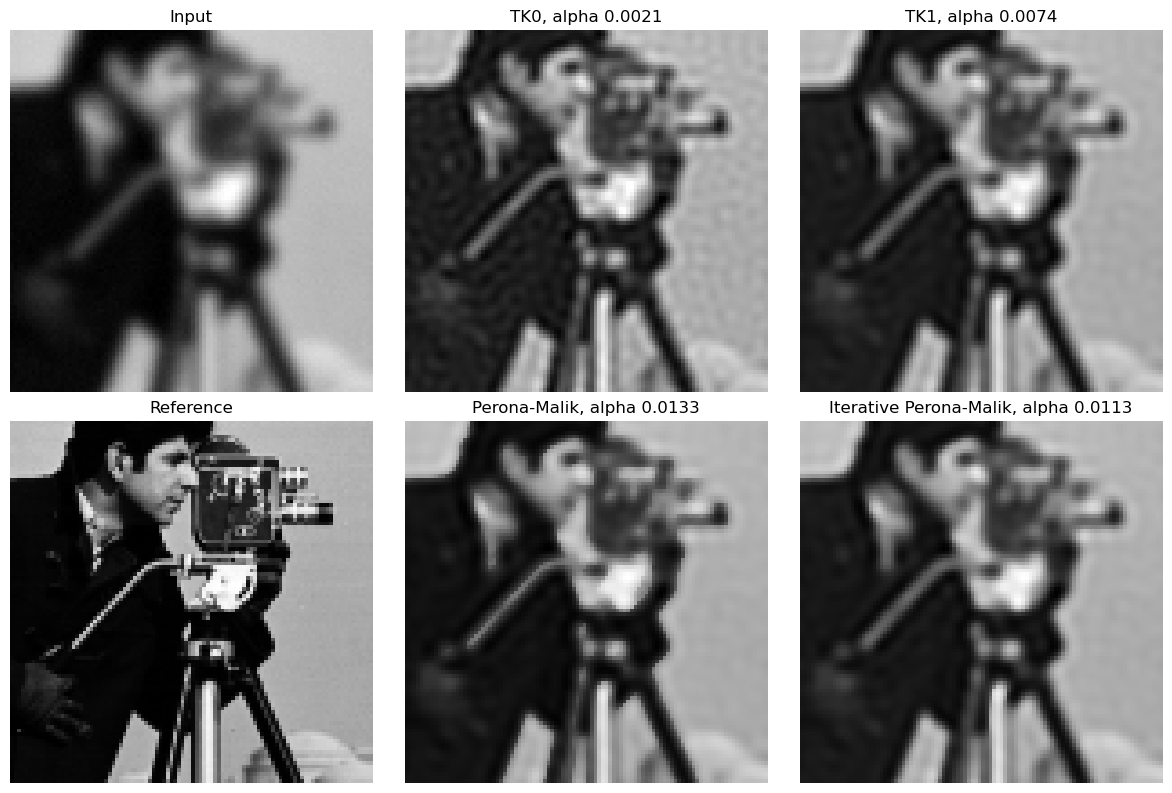

In [13]:
"""Compare regularisation techniques"""

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(g[50:150, 80:180], cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[1, 0].imshow(f[50:150, 80:180], cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 1].set_title(f"TK0, alpha {lsqr_tk0.optimal_alpha:.4f}")
axs[0, 1].axis("off")
axs[0, 2].imshow(lsqr_tk1.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 2].set_title(f"TK1, alpha {lsqr_tk1.optimal_alpha:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_pm.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 1].set_title(f"Perona-Malik, alpha {lsqr_pm.optimal_alpha:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm_iter.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 2].set_title(f"Iterative Perona-Malik, alpha {lsqr_pm_iter.optimal_alpha:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [14]:
print(f"TK0: optimal alpha {lsqr_tk0.optimal_alpha:.4f}")
print(lsqr_tk0.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"TK1: optimal alpha {lsqr_tk1.optimal_alpha:.4f}")
print(lsqr_tk1.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"Perona-Malik: optimal alpha {lsqr_pm.optimal_alpha:.4f}")
print(lsqr_pm.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"Iterative Perona-Malik: optimal alpha {lsqr_pm_iter.optimal_alpha:.4f}")
print(lsqr_pm_iter.optimal_metrics[["MSE", "pSNR", "SSIM"]])

TK0: optimal alpha 0.0021
MSE      0.003273
pSNR    24.850411
SSIM     0.736852
Name: optimal, dtype: object
TK1: optimal alpha 0.0074
MSE      0.003643
pSNR    24.385463
SSIM     0.784019
Name: optimal, dtype: object
Perona-Malik: optimal alpha 0.0133
MSE      0.002788
pSNR    25.546606
SSIM     0.814292
Name: optimal, dtype: object
Iterative Perona-Malik: optimal alpha 0.0113
MSE      0.003437
pSNR    24.638491
SSIM     0.797325
Name: optimal, dtype: object
